# Creating the Dataset

## Creating Parameter CSV file

### First step of creating the Dataset

This first step focuses on defining ranges parameters of different elements of the cardiac circulation (some ranged and some constant) – based on preset parameters from literature, and then randomising values for these parameters using Latin hypercube (a statistical method for generating a near-random sample of parameter values).

Start by importing the necessary modules
* Imported LatinHypercube from autoemulate module, experimental_design submodule
* Imported NaghaviModelParameters from ModularCirc Models submodule


In [49]:
%load_ext autoreload 
%autoreload 2

import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import os
import json
from autoemulate.experimental_design import LatinHypercube
from ModularCirc.Models.NaghaviModel import NaghaviModelParameters

# os.chdir("../utils") # need to change this!

import circ_utils
## Importing a .py file with functions needed to call the script to produce the output data

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/aalexander-ikwue/Documents/GitHub/SensitivityAnalysis/Tutorials


Define the folder path - adapt as necessary to your machine.

In [50]:
main_path = os.getcwd()
# print(current_dir)
# main_path = '/Users/aalexander-ikwue/Documents/GitHub/modular-circ-test' # Review this - change path
# Add instruuction to be in the tutorial file when running this

Imported a dictonary of parameters for structures in the heart, based on the Naghavi parameter values, with a range to allow for variablilty. Some values are constant and do not have  a range.

In [51]:

with open('parameters.json', 'r') as file:
    dict_parameters = json.load(file)

# dict_parameters = json.loads(parameters)
print(dict_parameters)

{'VESSELS': {'ao': {'r': [240, [0.5, 1.5]], 'c': [0.3, [0.5, 1.5]], 'l': [0], 'v_ref': [100], 'v': [130]}, 'art': {'r': [1125, [0.5, 1.5]], 'c': [3, [0.5, 1.5]], 'l': [0], 'v_ref': [900], 'v': [1092]}, 'ven': {'r': [9, [0.5, 1.5]], 'c': [133.3, [0.5, 1.5]], 'l': [0.0], 'v_ref': [2800], 'v': [3780]}}, 'VALVES': {'av': {'r': [6, [0.5, 1.5]]}, 'mv': {'r': [4.1, [0.5, 1.5]]}}, 'CHAMBERS': {'la': {'E_pas': [0.44, [0.5, 1.5]], 'E_act': [0.45, [0.5, 1.5]], 'v_ref': [10, [0.5, 1.5]], 'k_pas': [0.05, [0.333, 1.5]], 'v': [93], 'delay': [150], 't_tr': [225], 'tau': [25], 't_max': [150]}, 'lv': {'E_pas': [1.0, [0.5, 1.5]], 'E_act': [3, [0.5, 1.5]], 'v_ref': [10.0, [0.5, 1.5]], 'k_pas': [0.03, [0.333, 1.5]], 'delay': [0], 't_tr': [420], 'tau': [25], 't_max': [280]}}, 'T': [[800], [0.375, 1.5]]}


In [52]:
## This function splits the values from the parameter dictionary by full stops and separates the values that have ranges from those that don't have ranges.

dict_parameters_condensed_range = dict()
dict_parameters_condensed_single = dict()

def condense_dict_parameters(dict_param:dict, prev=""):
    for key, val in dict_param.items():
        if len(prev) > 0:
            new_key = prev.split('.')[-1] + '.' + key
        else:
            new_key = key
        if isinstance(val, dict):
            condense_dict_parameters(val, new_key)
        else:
            if len(val) > 1:
                value, r = val
                dict_parameters_condensed_range[new_key] = tuple(np.array(r) * value)
            else:
                dict_parameters_condensed_single[new_key] = val[0]
    return  

Use the function to condense the parameters into their respective groups (range or single) with the dictionary that we created. 

In [53]:
condense_dict_parameters(dict_parameters)

Choose the number of samples you would like to create and randomise values for each parameter set - and make the results into a dataframe.

In [54]:
N_samples = 50
lhd = LatinHypercube(dict_parameters_condensed_range.values())
sample_array = lhd.sample(N_samples)
sample_df    = pd.DataFrame(sample_array, columns=dict_parameters_condensed_range.keys())
sample_df.index.name = 'Index'
sample_df.head()

,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,la.v_ref,la.k_pas,lv.E_pas,lv.E_act,lv.v_ref,lv.k_pas,T
Index,,,,,,,,,,,,,,,,,
0,208.268052,0.226897,1464.344988,2.796835,12.450924,172.239728,8.645614,3.064622,0.327609,0.274754,9.002744,0.057397,0.980354,3.975648,5.414678,0.027877,549.030312
1,138.273154,0.417008,1061.329058,1.838026,4.839516,114.639377,6.409639,3.997419,0.599152,0.636396,13.718062,0.045342,1.132483,3.788910,11.921446,0.012624,462.523681
2,283.716771,0.411699,890.787308,1.559777,11.154489,109.384611,7.763275,3.715266,0.284978,0.296817,8.018356,0.027526,1.413359,2.927708,12.079473,0.020354,553.534991
3,281.533912,0.165719,1458.287598,4.105365,12.767017,112.033538,8.180023,5.934987,0.420030,0.610134,6.982382,0.032007,1.149917,3.701154,11.742820,0.014678,880.849911
4,151.881296,0.403542,695.786064,3.392454,8.175170,73.477356,8.483895,3.653721,0.653896,0.322999,12.192209,0.061299,1.042400,1.973614,5.848501,0.036854,1053.350979


Add the previously separated constants back into the new dataframe.

In [55]:
for key, val in dict_parameters_condensed_single.items():
    print(key, val)

    sample_df[key] = val
    ###
    sample_df[key] = val
    ###
sample_df.head()

ao.l 0
ao.v_ref 100
ao.v 130
art.l 0
art.v_ref 900
art.v 1092
ven.l 0.0
ven.v_ref 2800
ven.v 3780
la.v 93
la.delay 150
la.t_tr 225
la.tau 25
la.t_max 150
lv.delay 0
lv.t_tr 420
lv.tau 25
lv.t_max 280


,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,...,ven.v,la.v,la.delay,la.t_tr,la.tau,la.t_max,lv.delay,lv.t_tr,lv.tau,lv.t_max
Index,,,,,,,,,,,,,,,,,,,,,
0,208.268052,0.226897,1464.344988,2.796835,12.450924,172.239728,8.645614,3.064622,0.327609,0.274754,...,3780,93,150,225,25,150,0,420,25,280
1,138.273154,0.417008,1061.329058,1.838026,4.839516,114.639377,6.409639,3.997419,0.599152,0.636396,...,3780,93,150,225,25,150,0,420,25,280
2,283.716771,0.411699,890.787308,1.559777,11.154489,109.384611,7.763275,3.715266,0.284978,0.296817,...,3780,93,150,225,25,150,0,420,25,280
3,281.533912,0.165719,1458.287598,4.105365,12.767017,112.033538,8.180023,5.934987,0.420030,0.610134,...,3780,93,150,225,25,150,0,420,25,280
4,151.881296,0.403542,695.786064,3.392454,8.175170,73.477356,8.483895,3.653721,0.653896,0.322999,...,3780,93,150,225,25,150,0,420,25,280


Try and move this function to circ utils

In [56]:
def scale_time_parameters_and_asign_to_components(df):

# Scale the time parameters down based on specific pulse duration
# 800 ms in this case

    df['la.delay'] = df['la.delay'] * df['T'] / 800.
    
    df['la.t_tr'] = df['la.t_tr'] * df['T'] / 800.
    df['lv.t_tr'] = df['lv.t_tr'] * df['T'] / 800.
    
    df['la.tau'] = df['la.tau'] * df['T'] / 800.
    df['lv.tau'] = df['lv.tau'] * df['T'] / 800.

    df['la.t_max'] = df['la.t_max']  * df['T'] / 800.
    df['lv.t_max'] = df['lv.t_max']  * df['T'] / 800.
    return 

In [57]:
scale_time_parameters_and_asign_to_components(sample_df)

Save the complete file to a folder that will be used in  upcoming steps!
Used as input for emulation and running simulations.

In [58]:
sample_df.to_csv(f'{main_path}/data/input/input_parameters_{N_samples}.csv')

## Running Simulations

### Second step of creating the dataset

The randomised input parameters that we created in the first step will now be run through ModularCirc simulations – until a steady state is reached and pressure pulse traces are output.
The number of simulations that are run is based on the number of randomised parameter sets you created as you are generating the coresponding target variables (output).

Define the folder path:

In [59]:
output_path = f"../Tutorials/data/pressure_traces_{N_samples}"
input_file = f"../Tutorials/data/input/input_parameters_{N_samples}.csv"

In [60]:
parameter_data_frame = pd.read_csv(input_file, index_col="Index")
parameter_data_frame.head()

,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,...,ven.v,la.v,la.delay,la.t_tr,la.tau,la.t_max,lv.delay,lv.t_tr,lv.tau,lv.t_max
Index,,,,,,,,,,,,,,,,,,,,,
0,208.268052,0.226897,1464.344988,2.796835,12.450924,172.239728,8.645614,3.064622,0.327609,0.274754,...,3780,93,102.943183,154.414775,17.157197,102.943183,0,288.240914,17.157197,192.160609
1,138.273154,0.417008,1061.329058,1.838026,4.839516,114.639377,6.409639,3.997419,0.599152,0.636396,...,3780,93,86.723190,130.084785,14.453865,86.723190,0,242.824932,14.453865,161.883288
2,283.716771,0.411699,890.787308,1.559777,11.154489,109.384611,7.763275,3.715266,0.284978,0.296817,...,3780,93,103.787811,155.681716,17.297968,103.787811,0,290.605870,17.297968,193.737247
3,281.533912,0.165719,1458.287598,4.105365,12.767017,112.033538,8.180023,5.934987,0.420030,0.610134,...,3780,93,165.159358,247.739037,27.526560,165.159358,0,462.446203,27.526560,308.297469
4,151.881296,0.403542,695.786064,3.392454,8.175170,73.477356,8.483895,3.653721,0.653896,0.322999,...,3780,93,197.503309,296.254963,32.917218,197.503309,0,553.009264,32.917218,368.672843


The randomised parameters are run through ModularCirc simulations -  until a steady state is reached and pressure pulse traces are output. These are the coresponding target variables to the input parameters generated in the first step.

In [61]:
dt = 1.
## Describes the time resolution of the results
N_cycles = 30
# The maximum number of heartbeats used to run a simulation

# successful_runs = joblib.Parallel(n_jobs=5)(joblib.delayed(run_case)(row, path_out, N_cycles, dt) for _, row in tqdm(parameter_data_frame.loc[args.restart_from:].iterrows(), total=len(parameter_data_frame.loc[args.restart_from:])))
# This line of code is using the `joblib` library to parallelize the execution of the `run_case` function for each row in the `parameter_data_frame` DataFrame. It is creating multiple parallel jobs (5 in this case) to process the rows concurrently. The `tqdm` function is used to display a progress bar for tracking the completion of the jobs.
os.system(f'mkdir -p {output_path}')
os.system(f'rm {output_path}/*')
test = circ_utils.run_in_parallel(output_path, N_cycles, dt, parameter_data_frame)

done


Defines a dataframe for the values collected from the simulation

In [62]:
pressure_traces_df = circ_utils.simulation_loader(output_path)

Plotting the new dataframe:

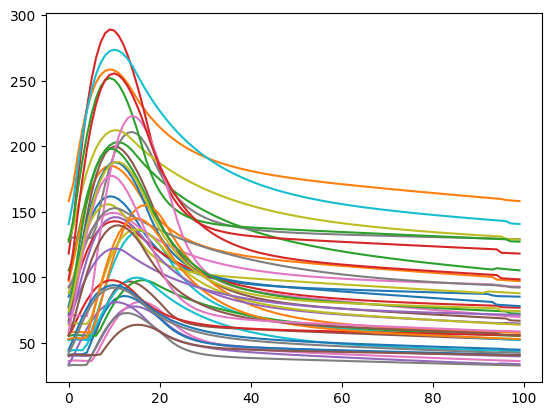

In [63]:
for _, row  in pressure_traces_df.iterrows():
    plt.plot(row.values[:100])
    
plt.show()